In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.plot import draw_raster_single
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real

In [2]:
def get_power1(Gamma):
    return Gamma[:,0,0].real

def get_power1dB(Gamma):
    return 10*np.log10(Gamma[:,0,0].real)

def get_coh(Gamma):
    return thr_coherence(Gamma)


from cohlib.utils import conv_v_to_z
def Gamma_est_from_zs(zs, dc=True):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean

In [3]:
mu = 0.0
K = 2
L = 25 
C = 1
sample_length = 1000
seed = 7
ov1 = 1.0


In [43]:
import os
import jax.numpy as jnp
import jax.random as jr
from cohlib.utils import gamma_root
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0


lseed = 7
oseed = 7
flow = 1
fhigh = 50
sp_target = 5
sp_offtarget = 2
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{sp_target}-{sp_offtarget}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
N = freqs.size
nz = gamma_load['nonzero_inds']
nz_target = jnp.array([9])
K = gamma_full.shape[-1]

lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)


In [44]:
ov2 = -2.0
ork = jr.key(oseed)


print(f"Sampling observations with variance {ov1}e^{ov2}")
obs_var = ov1 * 10**ov2
# obs_var = ocfg.ov1 * 10**{ocfg.ov2}
jax_ys = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)
ys = np.array(jax_ys)[:,None,:,:]



seed = 8
etype="approx"
model_path = f'saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
model_load = pickle_open(model_path)

Wv_model = model_load['Wv']
Wv = Wv_model
num_J_vars = Wv.shape[1]
freqs_mod = freqs[:int((Wv.shape[1]) / 2)]

J_max = int((Wv.shape[1])/2)


Sampling observations with variance 1.0e^-2.0


In [45]:
# from cohlib.mvcn import sample_mvcn_time_obs_nodc
# data_check_path = f'saved/synthetic_data/simple_synthetic_gaussian_2_25_1000_1_0.0_1.0_0.0_7' 
# check = pickle_open(data_check_path)
# nz = np.arange(50)
# Gamma_reduce = check['latent']['Gamma'][nz,:,:]
# freqs_reduce = freqs[nz]
# Wv_reduce = Wv

# check_xs, check_vs, check_zs = sample_mvcn_time_obs_nodc(Gamma_reduce, L, freqs_reduce, Wv_reduce, return_all=True)
# # S = check['latent']['Gamma'][:,0,0].real
# # plt.plot(S)
# # # plt.ylim([0,500])
# # plt.xlim([0,50])

In [46]:
# test = Wv.T @ ys[:,0,0,0]
vs_from_ys = jnp.einsum('jt,tkl->jkl', Wv.T, ys[:,0,:,:])
zs_from_ys = conv_v_to_z(vs_from_ys, axis=0)
gamma_from_ys = jnp.einsum('jkl,jil->jkil', zs_from_ys, zs_from_ys.conj()).mean(-1)

Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
# zs_naive = jnp.fft.rfft(ys, axis=0)[1:,0,:,:]
# gamma_naive = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

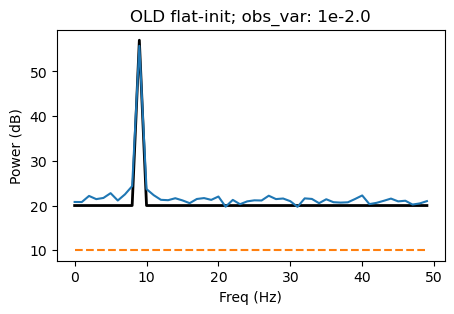

In [47]:
dB = True
seed = 8
etype="approx"
ovs = [-2]
# ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    # model_path = f'saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_path = f'saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    fig, ax = plt.subplots(figsize=(5,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500
    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_model = 10*np.log10(S_model)
        S_init = 10*np.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*np.log10(S_true)

    ax.plot(S_true, 'k', linewidth=2, label='True')
    # ax.plot(S_oracle, 'tab:green', label='Oracle')
    ax.plot(S_model, 'tab:blue', label='Model')
    ax.plot(S_init, 'tab:orange', linestyle='--', label='Model')
    ax.set_title(f'OLD flat-init; obs_var: 1e{ov2}')
    ax.set_xlabel('Freq (Hz)')
    if dB is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power ')
    if ov2 == -3:
        ax.legend()
    # plt.xlim([0,5])

In [34]:
zs.shape
Gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)

In [35]:
Gamma_oracle.shape

(50, 2, 2)

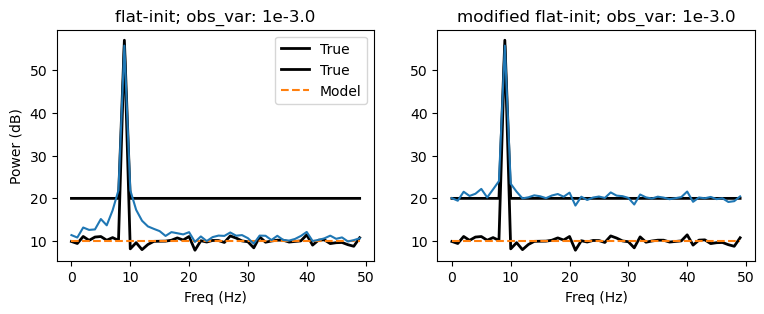

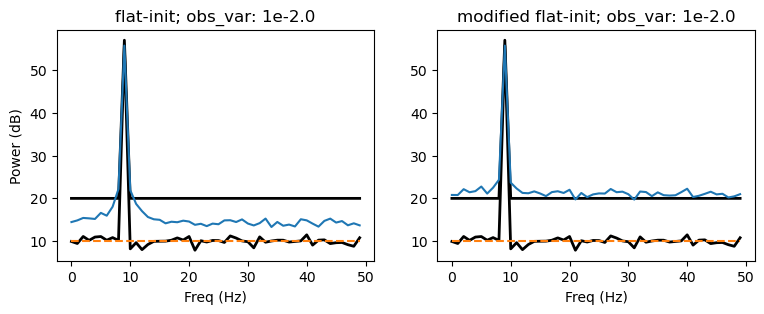

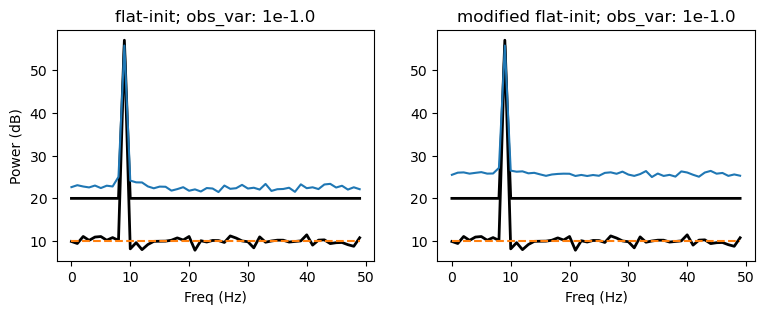

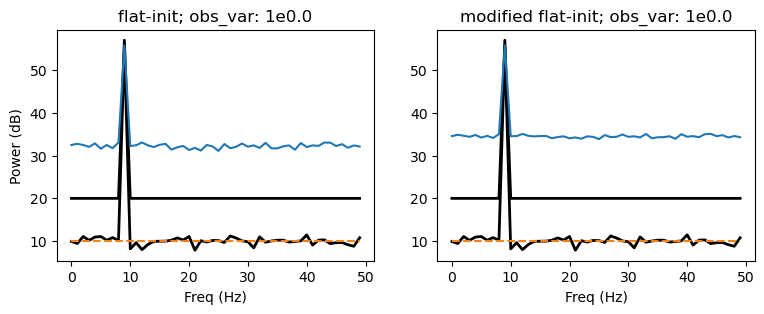

In [48]:
dB = True
seed = 8
etype="approx"
# ovs = [-2]
ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    model_path = f'saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    model_hessmod_path = f'saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_hessmod_load = pickle_open(model_hessmod_path)

    fig, ax = plt.subplots(1,2,figsize=(9,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500

    S_oracle = Gamma_oracle[:,0,0].real
    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_model_hessmod = model_hessmod_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_oracle = 10*np.log10(S_oracle)
        S_model = 10*np.log10(S_model)
        S_model_hessmod = 10*np.log10(S_model_hessmod)
        S_init = 10*np.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*np.log10(S_true)

    for i in range(2):
        ax[i].plot(S_true, 'k', linewidth=2, label='True')
        ax[i].plot(S_oracle, 'k', linewidth=2, label='True')
        # ax.plot(S_oracle, 'tab:green', label='Oracle')
        ax[i].plot(S_init, 'tab:orange', linestyle='--', label='Model')
        ax[i].set_xlabel('Freq (Hz)')
    ax[0].set_title(f'flat-init; obs_var: 1e{ov2}')
    ax[1].set_title(f'modified flat-init; obs_var: 1e{ov2}')
    if dB is True:
        ax[0].set_ylabel('Power (dB)')
    else:
        ax[0].set_ylabel('Power ')
    if ov2 == -3:
        ax[0].legend()
    # plt.xlim([0,5])
    ax[0].plot(S_model, 'tab:blue', label='Model')
    ax[1].plot(S_model_hessmod, 'tab:blue', label='Model')

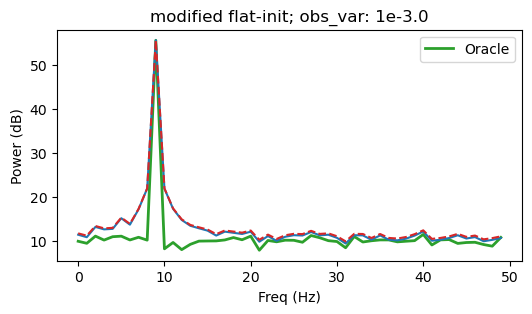

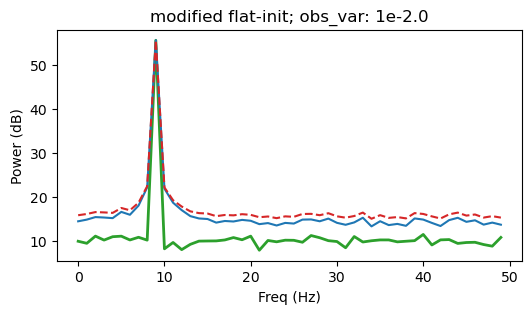

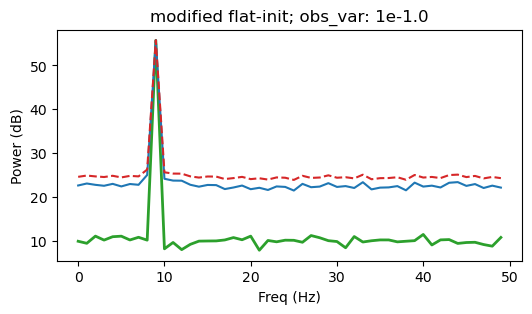

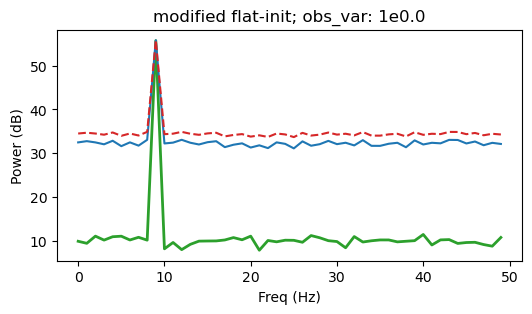

In [50]:
dB = True
seed = 8
etype="approx"
# ovs = [-2]
ovs = [-3, -2, -1, 0]
for ov2 in ovs:
    ov2 = float(ov2)
    model_path = f'saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_load = pickle_open(model_path)

    model_hessmod_path = f'saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
    model_hessmod_load = pickle_open(model_hessmod_path)

    fig, ax = plt.subplots(figsize=(6,3))
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars=100, invert=True)
    J = 500

    S_oracle = Gamma_oracle[:,0,0].real
    S_model = model_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_model_hessmod = model_hessmod_load['Gamma'][:,0,0].real #* ((2*J )**2 * (np.pi / (J + 1))**2)
    S_init = Gamma_init[:,0,0].real 
    S_true = gamma_full[:50,0,0].real 
    # S_naive = gamma_from_ys[:,0,0].real * (((J * np.pi)**2 / (J + 1)))

    if dB is True:
        S_oracle = 10*np.log10(S_oracle)
        S_model = 10*np.log10(S_model)
        S_model_hessmod = 10*np.log10(S_model_hessmod)
        S_init = 10*np.log10(S_init)
        # S_naive = 10*np.log10(S_naive)
        S_true = 10*np.log10(S_true)

    # ax.plot(S_true, 'k', linewidth=2, label='True')
    ax.plot(S_oracle, 'tab:green', linewidth=2, label='Oracle')
    # ax.plot(S_oracle, 'tab:green', label='Oracle')
    # ax.plot(S_init, 'tab:orange', linestyle='--', label='Init')
    ax.set_xlabel('Freq (Hz)')
    ax.set_title(f'flat-init; obs_var: 1e{ov2}')
    ax.set_title(f'modified flat-init; obs_var: 1e{ov2}')
    if dB is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power ')
    if ov2 == -3:
        ax.legend()
    # plt.xlim([0,5])
    ax.plot(S_model, 'tab:blue', label='Model')
    ax.plot(S_model_hessmod, 'tab:red', linestyle='--', label='Modified Model')
    # ax.set_xlim([5,15])
    # ax.set_ylim([0,10000])

### Wow ok so it did the opposite thing we thought it would do 

In [40]:
model_hessmod_load['track']

[[{'gamma_rplus1': array([[[ 7.86083844e+01+0.00000000e+00j,
             2.63856867e-01-4.39321699e-01j],
           [ 2.63856867e-01+4.39321699e-01j,
             7.87182923e+01+0.00000000e+00j]],
   
          [[ 7.88008887e+01+0.00000000e+00j,
            -1.21296045e-01-1.59473846e-01j],
           [-1.21296045e-01+1.59473846e-01j,
             7.83080395e+01+0.00000000e+00j]],
   
          [[ 7.86167445e+01+0.00000000e+00j,
            -1.87543232e-01-2.30138871e-01j],
           [-1.87543232e-01+2.30138871e-01j,
             7.80852167e+01+0.00000000e+00j]],
   
          [[ 7.83296790e+01+0.00000000e+00j,
             3.00462327e-01-2.40273978e-01j],
           [ 3.00462327e-01+2.40273978e-01j,
             7.83061838e+01+0.00000000e+00j]],
   
          [[ 7.89315767e+01+0.00000000e+00j,
             4.35164210e-01-1.20284185e-01j],
           [ 4.35164210e-01+1.20284185e-01j,
             7.87463867e+01+0.00000000e+00j]],
   
          [[ 7.81161236e+01+0.00000000e+00j,
    